In [12]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import SelectKBest

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.inspection import permutation_importance

from sklearn.tree import plot_tree

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
df_train=pd.read_csv("../ravdess_features_train_pulito.csv")
df_test=pd.read_csv("../ravdess_features_test_pulito.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

### Outliers dropping

In [3]:
#df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["emotion"]).values
y_train=df_train.emotion.values

#df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["emotion"]).values
y_test=df_test.emotion.values

### Features selection

In [17]:
#sel = SelectKBest(k=108)
#X_train = sel.fit_transform(X_train, y_train)
#X_test = sel.transform(X_test)

In [4]:
X_train.shape

(1828, 376)

# Random forest

In [5]:
clf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0, 
                             n_jobs=-1,
                             class_weight="balanced_subsample")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4791666666666667
F1-score [0.28787879 0.63926941 0.4516129  0.49056604 0.39473684 0.61751152
 0.32748538 0.45454545]
              precision    recall  f1-score   support

           0       0.53      0.20      0.29        96
           1       0.57      0.73      0.64        96
           2       0.40      0.51      0.45        96
           3       0.45      0.54      0.49        48
           4       0.54      0.31      0.39        48
           5       0.55      0.70      0.62        96
           6       0.37      0.29      0.33        96
           7       0.40      0.52      0.45        48

    accuracy                           0.48       624
   macro avg       0.48      0.48      0.46       624
weighted avg       0.48      0.48      0.46       624



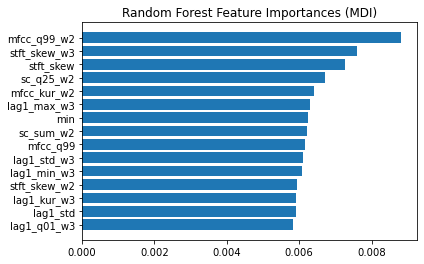

In [6]:
nbr_features = 15

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True)
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(df_train.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

In [7]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

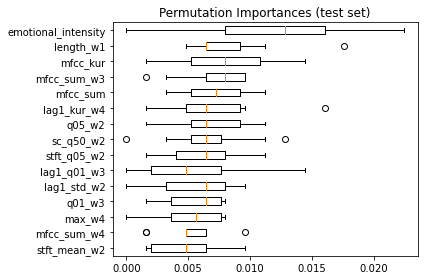

In [8]:
sorted_idx = result.importances_mean.argsort()[-nbr_features:]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(df_test.drop(columns=["emotion"]).columns)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [9]:
np.unique(y_train).tolist()

[0, 1, 2, 3, 4, 5, 6, 7]

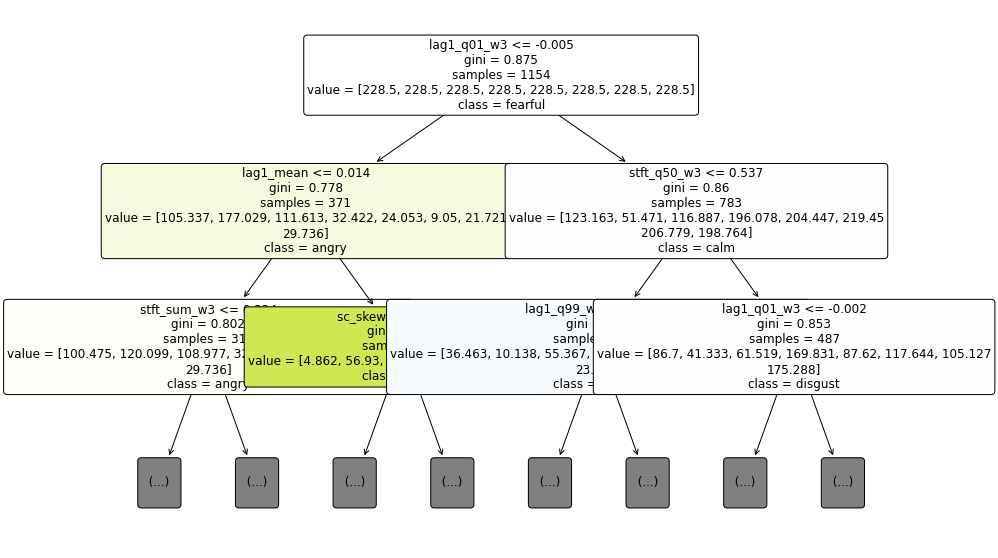

In [10]:
plt.figure(figsize=(14,10))
plot_tree(clf.estimators_[0], 
          feature_names=df_train.columns, 
          class_names=["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

### Hyperparameter tuning

In [13]:
'''
t1 = time.time()
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'criterion': ["gini", "entropy"], # log_loss doesn't work
              'max_features': ["sqrt", "log2", None],
              'n_estimators': [int(x) for x in np.linspace(100,1000,num=10)],
              'class_weight': ["balanced", None, "balanced_subsample"]
             }

grid_rdmforest = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=100)
grid_rdmforest.fit(X_train, y_train)
t2 = time.time()
print("durata", t2-t1, "secondi")
'''

KeyboardInterrupt: 

In [ ]:
#grid_rdmforest.best_params_

Best params model complete (OD): {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Max_features=None è praticamente un bagging di decision trees, lo facciamo dopo.

Best params modello con FS e OD: {'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': log2,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [28]:
clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=1, min_samples_split=2, max_features="sqrt", criterion="entropy", class_weight="balanced_subsample")
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.5
F1-score [0.31007752 0.64545455 0.48113208 0.50909091 0.49350649 0.61674009
 0.3375     0.46017699]
              precision    recall  f1-score   support

           0       0.61      0.21      0.31        96
           1       0.57      0.74      0.65        96
           2       0.44      0.53      0.48        96
           3       0.45      0.58      0.51        48
           4       0.66      0.40      0.49        48
           5       0.53      0.73      0.62        96
           6       0.42      0.28      0.34        96
           7       0.40      0.54      0.46        48

    accuracy                           0.50       624
   macro avg       0.51      0.50      0.48       624
weighted avg       0.51      0.50      0.48       624



In [14]:
y_test_pred_proba = clf.predict_proba(X_test)

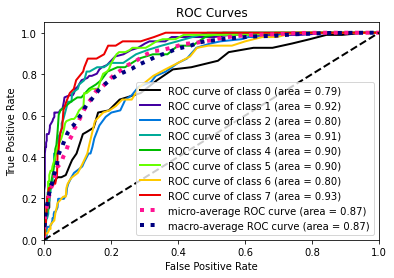

0.8690228703046086


In [15]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

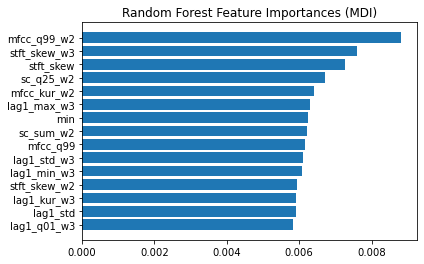

In [16]:
nbr_features = 15

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True)
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(df_train.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

# Bagging

In [ ]:
'''
param_list = {'base_estimator__min_samples_split': [2, 5, 10, 20],
              'base_estimator__min_samples_leaf': [1, 5, 10, 20],
              'n_estimators': [int(x) for x in np.linspace(100,1000,num=10)],
              'base_estimator__class_weight': ["balanced", None],
              'base_estimator__criterion': ["gini", "entropy"]
             }

grid_begging = RandomizedSearchCV(BaggingClassifier(DecisionTreeClassifier(max_features=None)),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=50)
grid_begging.fit(X_train, y_train)
'''

In [ ]:
#grid_begging.best_params_

Best params complete dataset(only OD): {'n_estimators': 400,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__criterion': 'entropy',
 'base_estimator__class_weight': None}

 Best params modello con FS e OD: {'n_estimators': 300,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__criterion': 'entropy',
 'base_estimator__class_weight': 'balanced'}

In [17]:
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1, min_samples_split=2, class_weight="balanced", criterion="entropy"), n_estimators=400, 
                        random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4967948717948718
F1-score [0.27642276 0.65437788 0.44670051 0.51785714 0.52083333 0.61111111
 0.30864198 0.528     ]
              precision    recall  f1-score   support

           0       0.63      0.18      0.28        96
           1       0.59      0.74      0.65        96
           2       0.44      0.46      0.45        96
           3       0.45      0.60      0.52        48
           4       0.52      0.52      0.52        48
           5       0.55      0.69      0.61        96
           6       0.38      0.26      0.31        96
           7       0.43      0.69      0.53        48

    accuracy                           0.50       624
   macro avg       0.50      0.52      0.48       624
weighted avg       0.50      0.50      0.47       624



In [18]:
y_test_pred_proba = clf.predict_proba(X_test)

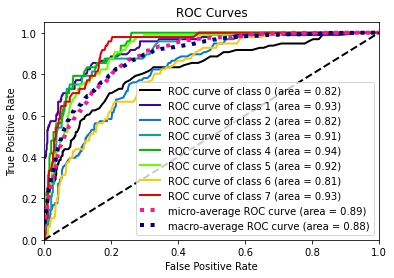

0.8838026258680556


In [19]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

# Boosting

In [ ]:
'''
param_list = {'base_estimator__min_samples_split': [2, 5, 10, 20],
              'base_estimator__min_samples_leaf': [1, 5, 10, 20],
              'n_estimators': [int(x) for x in np.linspace(100,1000,num=10)],
              'learning_rate': np.linspace(0.1,1,num=10),
              'base_estimator__class_weight': ["balanced", None],
              'base_estimator__criterion': ["gini", "entropy"]
             }

grid_boosting = RandomizedSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_features=None)),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=50)
grid_boosting.fit(X_train, y_train)
'''

In [ ]:
#grid_boosting.best_params_

Best params complete model (only OD): {'n_estimators': 500,
 'learning_rate': 0.5,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__criterion': 'entropy',
 'base_estimator__class_weight': 'balanced'}

 Best params modello con FS e OD: {'n_estimators': 500,
 'learning_rate': 0.30000000000000004,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__criterion': 'gini',
 'base_estimator__class_weight': None}

In [20]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1, min_samples_split=5, class_weight="balanced", criterion="entropy"), n_estimators=500, 
                        learning_rate=0.5, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4823717948717949
F1-score [0.41134752 0.61290323 0.42512077 0.44660194 0.34375    0.60550459
 0.33142857 0.5       ]
              precision    recall  f1-score   support

           0       0.64      0.30      0.41        96
           1       0.50      0.79      0.61        96
           2       0.40      0.46      0.43        96
           3       0.42      0.48      0.45        48
           4       0.69      0.23      0.34        48
           5       0.54      0.69      0.61        96
           6       0.37      0.30      0.33        96
           7       0.52      0.48      0.50        48

    accuracy                           0.48       624
   macro avg       0.51      0.47      0.46       624
weighted avg       0.50      0.48      0.47       624



In [21]:
y_test_pred_proba = clf.predict_proba(X_test)

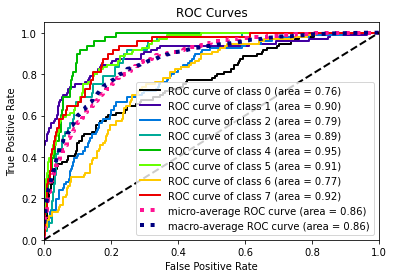

0.8622771497527356


In [22]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))